In [25]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np

ModuleNotFoundError: No module named 'sympy'

In [23]:
class ShaftVisualizer:
    def __init__(self):
        self.sections = []      # [(length, diameter)]
        self.supports = []      # [(position, type)]
        self.loads = []         # [(position, magnitude, type)]
    
    def add_section(self, length, diameter):
        """Agrega una nueva sección al eje."""
        self.sections.append((length, diameter))
    
    def add_support(self, position, type_):
        """Agrega un apoyo en la posición especificada."""
        if type_ not in ("simple", "empotrado"):
            raise ValueError("Tipo de apoyo no válido. Usa 'simple' o 'empotrado'.")
        self.supports.append((position, type_))
    
    def add_load(self, position, magnitude, type_="puntual"):
        """Agrega una carga en una posición (en kN)."""
        if type_ not in ("puntual",):
            raise ValueError("Tipo de carga no válido. Por ahora solo 'puntual'.")
        self.loads.append((position, magnitude, type_))
    
    def plot_shaft(self):
        """Dibuja el eje completo con secciones, apoyos y cargas."""
        if not self.sections:
            print("No hay secciones para dibujar.")
            return

        plt.figure(figsize=(10, 3))
        x0 = 0
        y_center = 0
        
        # --- Dibujo del eje ---
        for length, dia in self.sections:
            x1 = x0 + length
            y_top = y_center + dia/2
            y_bottom = y_center - dia/2
            plt.fill_between([x0, x1], y_bottom, y_top, color='lightgray', edgecolor='k')
            plt.text((x0 + x1)/2, y_top + dia * 0.1, f"Ø{dia} mm", ha='center', va='bottom', fontsize=8)
            plt.text((x0 + x1)/2, y_bottom - dia * 0.3, f"{length} mm", ha='center', va='top', fontsize=8)
            x0 = x1

        total_len = sum(l for l, _ in self.sections)
        max_dia = max(d for _, d in self.sections)
        
        # --- Dibujo de los apoyos ---
        for pos, tipo in self.supports:
            if tipo == "simple":
                self._draw_simple_support(pos, y_center - max_dia*0.8)
            elif tipo == "empotrado":
                self._draw_fixed_support(pos, y_center - max_dia*0.8, height=max_dia*1.2)
        
        # --- Dibujo de las cargas ---
        for pos, mag, tipo in self.loads:
            if tipo == "puntual":
                self._draw_point_load(pos, mag, y_center + max_dia*0.8)
        
        # --- Configuración del gráfico ---
        plt.title("Eje con secciones, apoyos y cargas")
        plt.xlabel("Longitud [mm]")
        plt.ylabel("Diámetro [mm]")
        plt.xlim(-10, total_len + 10)
        plt.ylim(-max_dia*2, max_dia*2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

    # ---- Apoyos ----
    def _draw_simple_support(self, x, y):
        """Dibuja un apoyo simple (triángulo)."""
        base = 10
        height = 8
        tri_x = [x - base/2, x + base/2, x]
        tri_y = [y, y, y + height]
        plt.fill(tri_x, tri_y, color='gray', edgecolor='k')
        plt.plot([x - base/2 - 3, x + base/2 + 3], [y, y], 'k', lw=1)

    def _draw_fixed_support(self, x, y, height=15):
        """Dibuja un apoyo empotrado (bloque negro)."""
        width = 4
        plt.fill_betweenx([y, y + height], x - width/2, x + width/2, color='black')
        plt.text(x, y + height + 5, "Empotrado", ha='center', va='bottom', fontsize=7)
    
    # ---- Cargas ----
    def _draw_point_load(self, x, magnitude, y_start):
        """Dibuja una carga puntual (flecha vertical)."""
        arrow_length = 20 * (abs(magnitude) / 10)  # escala relativa
        direction = 1 if magnitude < 0 else -1
        plt.arrow(x, y_start, 0, direction * -arrow_length, 
                  head_width=5, head_length=8, fc='red', ec='red', lw=1.5)
        plt.text(x, y_start + direction * (-arrow_length - 10),
                 f"{abs(magnitude)} kN", color='red', ha='center', va='top' if magnitude < 0 else 'bottom',
                 fontsize=8)

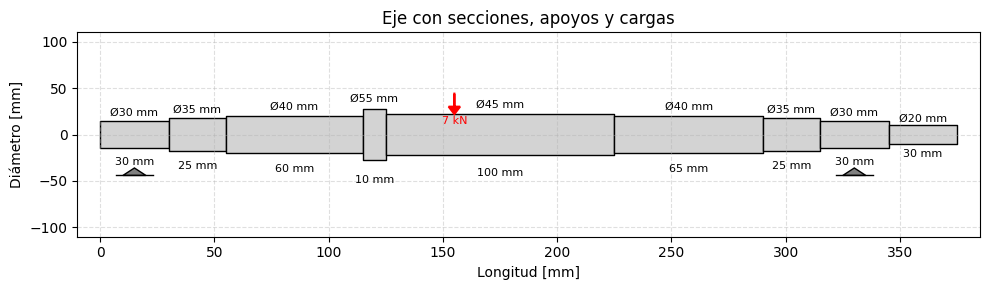

In [24]:
# Ejemplo de uso
shaft = ShaftVisualizer()

# Agregamos secciones (longitud en mm, diámetro en mm)
shaft.add_section(30, 30)
shaft.add_section(25, 35)
shaft.add_section(60, 40)
shaft.add_section(10, 55)
shaft.add_section(100, 45)
shaft.add_section(65, 40)
shaft.add_section(25, 35)
shaft.add_section(30, 30)
shaft.add_section(30, 20)

# Agregar apoyos
shaft.add_support(15, "simple")
shaft.add_support(330, "simple")

# Agregar cargas
shaft.add_load(155, -7, "puntual")  # 7 kN hacia abajo en x = 155 mm

shaft.plot_shaft()



In [ ]:
class ShaftStaticSolver:
    def __init__(self, sections, supports, loads):
        """
        sections: [(length, diameter)]
        supports: [(x_pos, type)] -> tipo: "simple" o "empotrado"
        loads: [(x_pos, magnitude, type)] -> tipo: "puntual"
        """
        self.sections = sections
        self.supports = supports
        self.loads = loads
        self.L_total = sum(l for l, _ in sections)
        self.reactions = {}
        self._x = sp.Symbol('x', real=True)
        
    def solve_reactions(self):
        """Resuelve las reacciones usando equilibrio estático plano."""
        # Solo funciona para eje con 2 apoyos (uno simple y uno empotrado)
        if len(self.supports) != 2:
            raise ValueError("Por ahora solo se soportan 2 apoyos.")

        (xA, typeA), (xB, typeB) = sorted(self.supports, key=lambda s: s[0])
        
        # Solo soporte vertical (sin momentos adicionales)
        R_A, R_B = sp.symbols('R_A R_B', real=True)
        
        # ΣFy = 0
        sum_forces = R_A + R_B + sum(L[1] for L in self.loads)
        
        # ΣM_A = 0
        sum_moments = R_B * (xB - xA)
        for xL, mag, _ in self.loads:
            sum_moments += mag * (xL - xA)
        
        sol = sp.solve([sp.Eq(sum_forces, 0), sp.Eq(sum_moments, 0)], (R_A, R_B))
        self.reactions = {xA: float(sol[R_A]), xB: float(sol[R_B])}
        return self.reactions

    def shear_moment_functions(self):
        """Devuelve funciones numéricas de esfuerzo cortante y momento flector."""
        if not self.reactions:
            self.solve_reactions()

        x = self._x
        V = 0
        for pos, val in self.reactions.items():
            V += val * sp.Heaviside(x - pos)
        for pos, mag, _ in self.loads:
            V += mag * sp.Heaviside(x - pos)
        
        M = sp.integrate(V, x)
        V_func = sp.lambdify(x, V, 'numpy')
        M_func = sp.lambdify(x, M, 'numpy')
        return V_func, M_func

    def compute_diagrams(self, n_points=300):
        """Devuelve arrays de x, V(x), M(x) para graficar."""
        V_func, M_func = self.shear_moment_functions()
        x_vals = np.linspace(0, self.L_total, n_points)
        V_vals = V_func(x_vals)
        M_vals = M_func(x_vals)
        return x_vals, V_vals, M_vals